In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist

class NormalNAMLSS(nn.Module):
    def __init__(self, n_covariates, hidden_size=16, intercept=False):
        super(NormalNAMLSS, self).__init__()

        self.submodules = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, 2)
            ) for _ in range(n_covariates)
        ])

        self.use_intercept = intercept
        if self.use_intercept:
            self.intercept = nn.Parameter(torch.zeros(2))

    def forward(self, x):
        param_mat_list = [self.submodules[i](x[:, i:i + 1]) for i in range(x.shape[1])]
        x = torch.stack(param_mat_list, dim=1)
        mu_components = x[:, :, 0]
        sigma_components = F.softplus(x[:, :, 1])

        mu = torch.sum(mu_components, dim=1).unsqueeze(dim=1)
        sigma = torch.sum(sigma_components, dim=1).unsqueeze(dim=1)

        if self.use_intercept:
            mu = mu + self.intercept[0]
            sigma = sigma + F.softplus(self.intercept[1])

        return mu, sigma

    def nll_loss(self, mu, sigma, y_true, robustness_factor=None):
        normal_dist = dist.Normal(mu, sigma)
        # log_likelihood = normal_dist.log_prob(y_true).sum()
        log_likelihood = normal_dist.log_prob(y_true).mean()

        if robustness_factor is not None:
            # log_likelihood = torch.log((1 + torch.exp(normal_dist.log_prob(y_true) + robustness_factor)) / (1 + torch.exp(robustness_factor))).sum()
            log_likelihood = torch.log((1 + torch.exp(normal_dist.log_prob(y_true) + robustness_factor)) / (1 + torch.exp(robustness_factor))).mean()

        nll = -log_likelihood
        return nll


    def fit(self, X_train, y_train, X_val=None, y_val=None, n_epochs=10000, lr=1e-3, weight_decay=0.0, 
            early_stopping_patience=10, robustness_factor=None):

        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(n_epochs):
            self.train()

            # Forward pass and loss computation
            mu, sigma = self.forward(X_train)
            train_loss = self.nll_loss(mu, sigma, y_train, robustness_factor)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            val_loss = None
            if X_val is not None and y_val is not None:
                self.eval()
                with torch.no_grad():
                    mu_val, sigma_val = self.forward(X_val)
                    val_loss = self.nll_loss(mu_val, sigma_val, y_val, robustness_factor).item()

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    best_model_state = self.state_dict()
                else:
                    patience_counter += 1

                if (patience_counter >= early_stopping_patience) and (epoch >= 1000):
                    print(f"Early stopping at epoch {epoch}. Best validation loss: {best_val_loss:.4f}")
                    self.load_state_dict(best_model_state)
                    break

            if epoch % 100 == 0 or val_loss is not None:
                # print(f"Epoch {epoch} - Train Loss: {train_loss.item():.4f} - Val Loss: {val_loss:.4f}" if val_loss else f"Epoch {epoch} - Train Loss: {train_loss.item():.4f}")
                pass

        return self
    
    def predict(self, x):
        mu, sigma = self.forward(x)

        mu = mu.detach()
        sigma = sigma.detach()

        return mu, sigma
        

    def marginal_effects(self, x):
        with torch.no_grad():
            param_mat_list = [self.submodules[i](x[:, i:i + 1]) for i in range(x.shape[1])]
            x = torch.stack(param_mat_list, dim=1)
            mu_components = x[:, :, 0].detach().cpu().numpy()
            sigma_components = F.softplus(x[:, :, 1]).detach().cpu().numpy()
        return mu_components, sigma_components

In [3]:
def rho_gradient(z, c):
    return np.exp(z + c)/(1 + np.exp(z + c))

In [4]:
import numpy as np

def get_aeberhard_penalty(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, target_mdp, verbose = F):

    rob_vec = torch.tensor(list(np.arange(2.5, 0, -0.1)), dtype = torch.float32)
    n_var = X_train_scaled.shape[1]
    
    prev_mdp = 0
    best_rob = None

    for rob in rob_vec:
        prev_distance = abs(prev_mdp - target_mdp)
        w_b_vector = []

        candidate_model = NormalNAMLSS(n_var)
        candidate_model.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor = rob)
        mu, sigma = candidate_model.predict(X_train_scaled)

        normal_dist = dist.Normal(mu, sigma)

        for _ in range(10):
            y_b = torch.normal(mu, sigma)
            ll = normal_dist.log_prob(y_b)
            w_1b = rho_gradient(ll, rob)
            w_b = torch.sum(w_1b) / len(y_b)
            w_b_vector.append(w_b)

        current_mdp = 1 - torch.median(torch.tensor(w_b_vector, dtype = torch.float32))
        current_distance = abs(current_mdp - target_mdp)

        if current_distance > prev_distance:
            print(f"stopping at {best_rob} --> mdp: {prev_mdp * 100}%")
            break

        best_rob = rob
        prev_mdp = current_mdp

        print(f"current_rob = {rob} --> mdp = {prev_mdp}%")

    return best_rob

In [5]:
import pandas as pd

hemoglobin = pd.read_csv("Hb-Anon.txt", delimiter="\t")
hemoglobin.head()

,VAL,PID,SEX,AGE
0,9.9,16454397634,M,698
1,13.6,94527474619,M,4538
2,14.4,84895945689,W,5830
3,11.3,99523414726,W,35
4,7.7,56793098059,W,612


In [6]:
hemoglobin = hemoglobin[hemoglobin["AGE"] > 365]
hemoglobin = hemoglobin[hemoglobin["AGE"] < 6570]
len(hemoglobin)

212653

In [7]:
import random

female_df = hemoglobin[hemoglobin["SEX"]=="W"][["AGE", "VAL"]]
female_df = female_df.to_numpy()

training_sample_indices = random.sample(range(1, len(female_df)), int(10000))
x_train = female_df[training_sample_indices, 0]
y_train = female_df[training_sample_indices, 1]

validation_sample_indices = random.sample(range(1, len(female_df)), int(10000))
x_val = female_df[validation_sample_indices, 0]
y_val = female_df[validation_sample_indices, 1]

testing_sample_indices = random.sample(range(1, len(female_df)), int(10000))
x_test = female_df[testing_sample_indices, 0]
y_test = female_df[testing_sample_indices, 1]

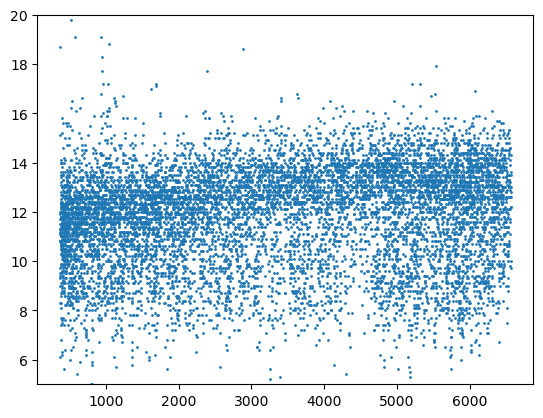

In [8]:
import matplotlib.pyplot as plt

plt.plot(x_test, y_test, "o", markersize = 1)
plt.ylim(5, 20)

plt.show()

In [9]:
x_train = torch.tensor(x_train).unsqueeze(1)
x_val = torch.tensor(x_val).unsqueeze(1)
x_test = torch.tensor(x_test).unsqueeze(1)

y_train = torch.tensor(y_train).unsqueeze(1)
y_val = torch.tensor(y_val).unsqueeze(1)
y_test = torch.tensor(y_test).unsqueeze(1)

In [10]:
from sklearn.preprocessing import StandardScaler

x_scaler, y_scaler = StandardScaler(), StandardScaler()

x_train_scaled = torch.tensor(x_scaler.fit_transform(x_train), dtype = torch.float32)
x_val_scaled = torch.tensor(x_scaler.transform(x_val), dtype = torch.float32)
x_test_scaled = torch.tensor(x_scaler.transform(x_test), dtype = torch.float32)

y_train_scaled = torch.tensor(y_scaler.fit_transform(y_train), dtype = torch.float32)
y_val_scaled = torch.tensor(y_scaler.transform(y_val), dtype = torch.float32)
y_test_scaled = torch.tensor(y_scaler.transform(y_test), dtype = torch.float32)


In [11]:
# robust_c = get_aeberhard_penalty(x_train_scaled, y_train_scaled, x_val_scaled, y_val_scaled, 0.5)
# strict_c = get_aeberhard_penalty(x_train_scaled, y_train_scaled, x_val_scaled, y_val_scaled, 0.6)

- 5%: rob = 4.4 --> mdp = 5.17
- 10%: rob = 3.5 --> mdp = 10.2
- 20%: rob = 2.5 --> mdp = 19.5
- 30%: rob = 1.6 --> mdp = 30.0
- 40%: rob = 0.9 --> mdp = 39.98
- 50%: rob = 0.3 --> mdp = 49.98

In [13]:
nam = NormalNAMLSS(1)
nam.fit(x_train_scaled, y_train_scaled, x_val_scaled, y_val_scaled)

# robust_nam = NormalNAMLSS(1)
# robust_nam.fit(x_train_scaled, y_train_scaled, x_val_scaled, y_val_scaled, robustness_factor = torch.tensor(robust_c))

strict_nam = NormalNAMLSS(1)
strict_nam .fit(x_train_scaled, y_train_scaled, x_val_scaled, y_val_scaled, robustness_factor = torch.tensor(0.3))

Early stopping at epoch 1000. Best validation loss: 0.4369


NormalNAMLSS(
  (submodules): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)

In [14]:
# Predicting parameters based on scaled values
mu, sigma = nam.predict(x_test_scaled)
robust_mu, robust_sigma = robust_nam.predict(x_test_scaled)
strict_mu, strict_sigma = strict_nam.predict(x_test_scaled)

# Rescaling the predictions for plotting
mu = mu * y_scaler.scale_ + y_scaler.mean_
robust_mu = robust_mu * y_scaler.scale_ + y_scaler.mean_
strict_mu = strict_mu * y_scaler.scale_ + y_scaler.mean_

sigma = sigma * y_scaler.scale_
robust_sigma = robust_sigma * y_scaler.scale_
strict_sigma = strict_sigma * y_scaler.scale_

# Calculating 95% reference interval bounds
regular_bounds = [mu - 1.96 * sigma, mu + 1.96 * sigma]
robust_bounds = [robust_mu - 1.96 * robust_sigma, robust_mu + 1.96 * robust_sigma]
strict_bounds = [strict_mu - 1.96 * strict_sigma, strict_mu + 1.96 * strict_sigma]



Text(0.5, 1.0, 'Estimated 95% reference intervals of healthy hemoglobin levels')

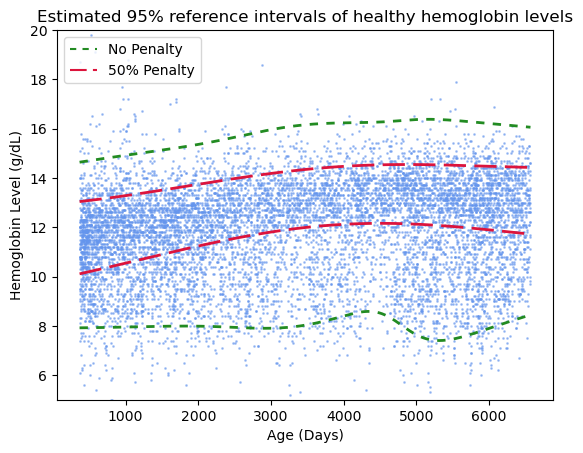

In [20]:
unregulated_color = "forestgreen"
robust_color = "indigo"
strict_color = "crimson"
dot_color = "cornflowerblue"

linestyle1 = (0, (3, 3))
linestyle2 = (0, (8, 3))
linewidth = 2

# Sorting values for plotting
sorted_indices = np.argsort(x_test.squeeze())
x_test_sorted = x_test[sorted_indices]
y_test_sorted = y_test[sorted_indices]

plt.plot(x_test_sorted, y_test_sorted, "o", markersize = 1, color = dot_color, alpha = 0.5)
plt.plot(x_test_sorted, regular_bounds[0][sorted_indices], color = unregulated_color, linestyle = linestyle1, linewidth = linewidth)
plt.plot(x_test_sorted, regular_bounds[1][sorted_indices], color = unregulated_color, linestyle = linestyle1, linewidth = linewidth)
# plt.plot(x_test_sorted, robust_bounds[0][sorted_indices], color = robust_color, linestyle = linestyle, linewidth = linewidth)
# plt.plot(x_test_sorted, robust_bounds[1][sorted_indices], color = robust_color, linestyle = linestyle, linewidth = linewidth)
plt.plot(x_test_sorted, strict_bounds[0][sorted_indices], color = strict_color, linestyle = linestyle2, linewidth = linewidth)
plt.plot(x_test_sorted, strict_bounds[1][sorted_indices], color = strict_color, linestyle = linestyle2, linewidth = linewidth)
plt.ylim((5,20))
plt.xlabel("Age (Days)")
plt.ylabel("Hemoglobin Level (g/dL)")

legend_handles = [
    plt.Line2D([0], [0], color=unregulated_color, label="No Penalty", linestyle = linestyle1),
    # plt.Line2D([0], [0], color=robust_color, label="40% Penalty"),
    plt.Line2D([0], [0], color=strict_color, label="50% Penalty", linestyle = linestyle2)
]

plt.legend(handles = legend_handles, loc = "upper left")
plt.title("Estimated 95% reference intervals of healthy hemoglobin levels")